In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

#output_df = pd.read_csv("../csv-files/CLs_predictions/4l_128n_75e_0.005lr_MAE_with_all_data.csv")
#output_df = pd.read_csv("../csv-files/CLs_predictions/4l_128n_EWKino_with_all_CLs_predictions.csv")
output_df = pd.read_csv("../csv-files/EWKino.csv")

CLs_labels = ['FullHad', '1Lbb', '2L0J', '2L2J', 'Compressed', '3LOffshell', '3LOnshell', '4L', 'DisappearingTrack', 'h_to_inv', 'mA']

In [59]:
def convert_to_heatmap_form(data: [[int]]) -> np.array:
    
    # Reverse array order so plots are in standard form of origin in bottom left (rather than top left)
    #data = data[::-1]
    
    # Convert to numpy arrays for easier handling
    return np.array(data)

def recreate_figure_4_7a_from_BenH_thesis(df, num_bins):
    
    plt.style.use('default')
    
    # Get 1st and 2nd neutralino masses for each SUSY model
    m_chi_1p = df["m_chi_1p"]
    m_chi_10 = df["m_chi_10"]
    
    # Create mass bins for plotting
    M1_bins = np.linspace(0, 1200, num_bins+1)
    M2_bins = np.linspace(0, 500, num_bins+1)
    
    frac_excluded = []
    
    for i in range(num_bins):
        
        frac_excluded_rows = []
        
        for j in range(num_bins):
            
            # Select models in particular bin
            bin_mask = (m_chi_1p >= M1_bins[j]) & (m_chi_1p < M1_bins[j+1]) & (m_chi_10 >= M2_bins[i]) & (m_chi_10 < M2_bins[i+1])
            
            # Get number of excluded models and total models in bin
            bin_excluded = (df[bin_mask]["FullHad__ObsCLs"] < 0.05).sum()
            bin_total = (df[bin_mask]["FullHad__ObsCLs"] < 2).sum()
            
            # Add fraction excluded in bin to heatmap array
            if bin_total != 0:
                bin_frac_excluded = bin_excluded / bin_total
            else:
                bin_frac_excluded = float('nan')
                        
            frac_excluded_rows.append(bin_frac_excluded)
            
        frac_excluded.append(frac_excluded_rows)
    
    # Convert arrays into a better form for heatmap plotting
    frac_excluded = np.array(frac_excluded)
    
    # Make 2D heatmap plots
    fig_x=np.linspace(0, 1200, num_bins)
    fig_y=np.linspace(0, 500, num_bins)
    
    fig_true = px.imshow(frac_excluded, 
                         labels=dict(x="m_chi_1p [GeV]", y="m_chi_10 [GeV]", color="Fraction of models excluded"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="EWKino scan, FullHad exclusion", aspect='square')
    
    fig_true.show()

recreate_figure_4_7a_from_BenH_thesis(output_df, 15)

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Number of models in bins of LSP mass (scaled to match pMSSM paper)'}, xlabel='m_chi_10 [GeV]', ylabel='Number of models'>)

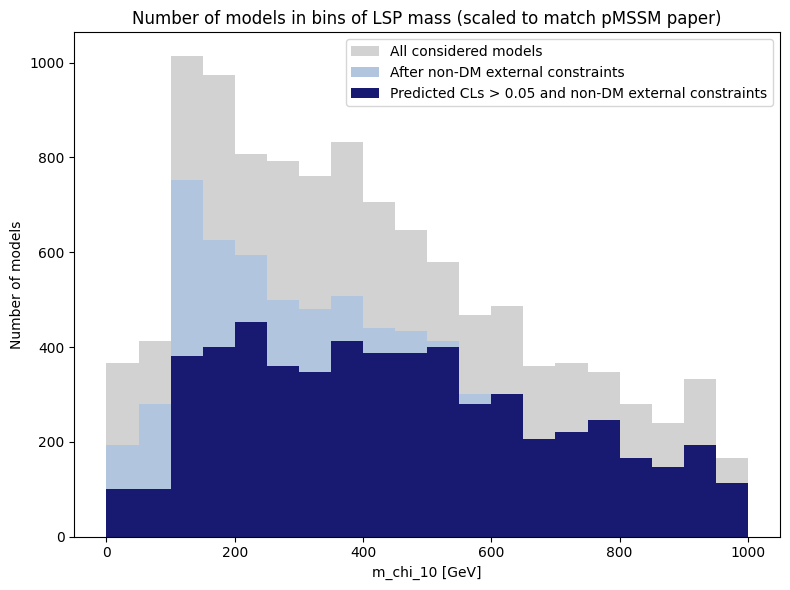

In [18]:
# Recreating figure 4 from pMSSM paper
def recreate_figure_4b_from_pMSSM_paper(df, num_bins):
    
    m_chi_10 = df["m_chi_10"]
    valid_CLs_models = df["Predicted_Final__CLs"] > 0.05
    valid_external_constraints_models = (df["Constraints__Flavour"] == 1) & (df["Constraints__EW"] == 1)
    
    # For figure 4a, you need to split dataset into bino-, wino-, and higgsino-like LSP. Doesn't work well because numbers are too small to be smooth
    bino_like_LSP = df["LSP_type"] == 1
    wino_like_LSP = df["LSP_type"] == 2
    higgsino_like_LSP = df["LSP_type"] == 3
    
    # Create bins
    bins = np.linspace(0, 1000, num_bins + 1)
    
    # Compute number of models for each bin
    number_of_models_by_bin = []
    valid_external_constraints_by_bin = []
    allowed_models_by_bin = []
    
    bin_centers = []
    
    for i in range(num_bins):
        # Find indices of values in this bin
        bin_mask = (m_chi_10 >= bins[i]) & (m_chi_10 < bins[i+1])
        valid_external_constraints_bin_mask = bin_mask & valid_external_constraints_models
        valid_CLs_and_external_constraints_bin_mask = bin_mask & valid_CLs_models & valid_external_constraints_models
        
        # Calculate number of models for this bin
        number_of_models = bin_mask.sum()
        num_valid_external_constraints_models = valid_external_constraints_bin_mask.sum()
        num_valid_CLs_and_external_constraints_models = valid_CLs_and_external_constraints_bin_mask.sum()
        
        # We only have 15% of the original dataset as we trained on the first 85%. Rescale to original to make a fair comparison
        scaled_number_of_models = number_of_models / 0.15
        scaled_num_external_constraints = num_valid_external_constraints_models / 0.15
        scaled_num_of_valid_models = num_valid_CLs_and_external_constraints_models / 0.15
        
        # Store results in array
        number_of_models_by_bin.append(scaled_number_of_models)
        valid_external_constraints_by_bin.append(scaled_num_external_constraints)
        allowed_models_by_bin.append(scaled_num_of_valid_models)
        bin_centers.append((bins[i] + bins[i+1]) / 2)
    
    # Create the plot
    plt.figure(figsize=(8,6))
    plt.bar(bin_centers, number_of_models_by_bin, width=(bins[1]-bins[0]), color="#d2d2d3")
    plt.bar(bin_centers, valid_external_constraints_by_bin, width=(bins[1]-bins[0]), color="#b1c5de")
    plt.bar(bin_centers, allowed_models_by_bin, width=(bins[1]-bins[0]), color="#181971")
    
    plt.title('Number of models in bins of LSP mass (scaled to match pMSSM paper)')
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('Number of models')
    
    plt.tight_layout()
    plt.legend(["All considered models", "After non-DM external constraints", "Predicted CLs > 0.05 and non-DM external constraints"])
    #plt.savefig("../plots/CLs_predictor_performance/recreate_figure_4b.pdf")
    
    return plt.gcf(), plt.gca()

recreate_figure_4b_from_pMSSM_paper(output_df, 20)

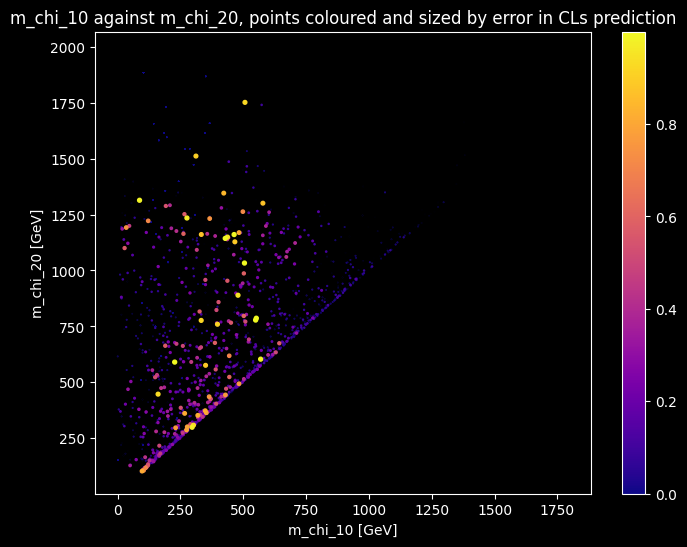

In [16]:
def scatter_plot_of_MAE(df):
    
    sorted_df = df
    sorted_df["abs_error"] = abs(df["Final__CLs"] - df["Predicted_Final__CLs"])
    sorted_df = sorted_df.sort_values(by='abs_error')
    
    # Get 1st and 2nd neutralino masses for each SUSY model
    m_chi_10 = sorted_df["m_chi_10"]
    m_chi_20 = sorted_df["m_chi_20"]
    
    # Get error in CLs prediction for each model
    abs_pred_error = sorted_df['abs_error']
    
    # Identify models for which error is large (i.e. prediction is bad)
    large_errors = abs_pred_error > 0.02
    
    plt.style.use('dark_background')
    
    plt.figure(figsize=(8,6))
    plt.scatter(m_chi_10, m_chi_20, c=abs_pred_error, cmap='plasma', s=abs_pred_error*8) #s=abs_pred_error*5
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('m_chi_20 [GeV]')
    plt.colorbar()
    plt.title('m_chi_10 against m_chi_20, points coloured and sized by error in CLs prediction')
    #plt.savefig('../plots/CLs_predictor_performance/4l_128n_75e_MAE_plots/scatter_plot_coloured_by_CLs_error.png')
    
    '''
    plt.figure(figsize=(8,6))
    plt.scatter(m_chi_10[large_errors], m_chi_20[large_errors], c=abs_pred_error[large_errors], cmap='plasma', s=abs_pred_error[large_errors]*10)
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('m_chi_20 [GeV]')
    plt.colorbar()
    '''

scatter_plot_of_MAE(df=output_df)

In [72]:
output_df = pd.read_csv("../csv-files/CLs_predictions/4l_128n_EWKino_with_all_CLs_predictions.csv")

def convert_to_heatmap_form(data: [[int]]) -> np.array:
    
    # Reverse array order so plots are in standard form of origin in bottom left (rather than top left)
    #data = data[::-1]
    
    # Convert to numpy arrays for easier handling
    return np.array(data)

def heatmap(df: pd.DataFrame, CLs_type: str, num_bins: int):
    
    true_CLs_name = f'{CLs_type}__ObsCLs'
    pred_CLs_name = f'Predicted_{CLs_type}_CLs'
    if CLs_type == 'Final__CLs': # Final__CLs column name is in different form
        true_CLs_name = 'Final__CLs'
        pred_CLs_name = 'Predicted_Final__CLs'
    
    plt.style.use('default')
    
    # Get 1st and 2nd neutralino masses for each SUSY model
    m_chi_10 = df["m_chi_10"]
    m_chi_20 = df["m_chi_20"]
    
    # Create mass bins for plotting
    '''M1_bins = np.linspace(0, 500, num_bins+1)
    M2_bins = np.linspace(0, 500, num_bins+1)'''
    
    M1_bins = np.linspace(0, max(m_chi_10), num_bins+1)
    M2_bins = np.linspace(0, max(m_chi_20), num_bins+1)
    
    mean_true_CLs = []
    mean_pred_CLs = []
    model_count = []
    CLs_MAE = []
    correct_exclusions = []
    
    for i in range(num_bins):
        
        mean_j_true_CLs = []
        mean_j_pred_CLs = []
        j_model_count = []
        j_CLs_MAE = []
        j_correct_exclusions = []
        
        for j in range(num_bins):
            
            # Select models in particular bin
            bin_mask = (m_chi_10 >= M1_bins[j]) & (m_chi_10 < M1_bins[j+1]) & (m_chi_20 >= M2_bins[i]) & (m_chi_20 < M2_bins[i+1])
            
            # Get true and predicted CLs in bin
            bin_true_CLs = df[bin_mask][true_CLs_name]
            bin_pred_CLs = df[bin_mask][pred_CLs_name]
            
            # Get mean true and predicted CLs in bin
            mean_bin_true_CLs = bin_true_CLs.mean()
            mean_bin_pred_CLs = bin_pred_CLs.mean()
            
            # Get number of models in bin
            bin_model_count = bin_mask.sum()
            if bin_model_count == 0:
                bin_model_count = float("nan")
                
            # Get MAE in bin
            bin_MAE = abs(bin_true_CLs - bin_pred_CLs).mean()
            
            # Get number of correctly excluded models in each bin
            bin_correct_exclusions = ((df[bin_mask][true_CLs_name] < 0.05) & (df[bin_mask][pred_CLs_name] < 0.05)).sum()
            if bin_correct_exclusions == 0:
                bin_correct_exclusions = float("nan")
            
            mean_j_true_CLs.append(mean_bin_true_CLs)
            mean_j_pred_CLs.append(mean_bin_pred_CLs)
            j_model_count.append(bin_model_count)
            j_CLs_MAE.append(bin_MAE)
            j_correct_exclusions.append(bin_correct_exclusions)
            
        mean_true_CLs.append(mean_j_true_CLs)
        mean_pred_CLs.append(mean_j_pred_CLs)
        model_count.append(j_model_count)
        CLs_MAE.append(j_CLs_MAE)
        correct_exclusions.append(j_correct_exclusions)
    
    # Convert arrays into a better form for heatmap plotting
    mean_true_CLs = convert_to_heatmap_form(mean_true_CLs)
    mean_pred_CLs = convert_to_heatmap_form(mean_pred_CLs)
    model_count = convert_to_heatmap_form(model_count)
    CLs_MAE = convert_to_heatmap_form(CLs_MAE)
    correct_exclusions = convert_to_heatmap_form(correct_exclusions)
    
    # Make 2D heatmap plots
    fig_x=np.linspace(0, 500, num_bins)
    fig_y=np.linspace(0, 500, num_bins)
    
    fig_true = px.imshow(mean_true_CLs, 
                         labels=dict(x="m_chi_10 [GeV]", y="m_chi_20 [GeV]", color="True CLs"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="True mean CLs heatmap")
    
    fig_pred = px.imshow(mean_pred_CLs,
                         labels=dict(x="m_chi_10 [GeV]", y="m_chi_20 [GeV]", color="Predicted CLs"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="Predicted mean CLs heatmap")
    
    fig_diff = px.imshow(abs(mean_true_CLs - mean_pred_CLs),
                         labels=dict(x="m_chi_10 [GeV]", y="m_chi_20 [GeV]", color="True - predicted CLs"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title=f"Difference {CLs_type} CLs heatmap")
    
    fig_count = px.imshow(model_count, 
                          labels=dict(x="m_chi_10 [GeV]", y="m_chi_20 [GeV]", color="Number of models"), 
                          x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="Number of models heatmap")
    
    fig_MAE = px.imshow(CLs_MAE, 
                        labels=dict(x="m_chi_10 [GeV]", y="m_chi_20 [GeV]", color="MAE"), 
                        x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="MAE heatmap")
    
    fig_excl = px.imshow(correct_exclusions,
                         labels=dict(x="m_chi_10 [GeV]", y="m_chi_20 [GeV]", color="Correct exclusions"), 
                         x=fig_x, y=fig_y, origin="lower", width=800, height=600, title="Correct exclusions heatmap")
    
    # This is all transparency mask stuff
    '''
    # Get number of models in each bin and normalise to [0,1] to use as transparency mask
    norm_model_count = model_count
    norm_model_count = np.nan_to_num(norm_model_count)
    norm_model_count = norm_model_count / np.max(norm_model_count)
    
    # matplotlib plotting
    plt_fig_x = np.linspace(0, max(m_chi_10), num_bins)
    plt_fig_y = np.linspace(0, max(m_chi_20), num_bins)
    fig, ax = plt.subplots()
    im = ax.imshow(mean_true_CLs, cmap='plasma', origin='lower', alpha=norm_model_count)
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('m_chi_20 [GeV]')
    plt.title('True mean CLs heatmap')
    ax.set_xticks(range(len(plt_fig_x))[::5], labels=plt_fig_x[::5],
              rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(plt_fig_y))[::5], labels=plt_fig_y[::5])
    plt.colorbar(im)
    plt.show()
    
    #plt.colorbar()
    #plt.show()
    '''
    
    #fig_true.show()    
    #fig_pred.show()
    fig_diff.show()
    #fig_count.show()
    #fig_MAE.show()
    # fig_excl.show()
    
    # Saving heatmaps
    '''
    fig_true.write_image('../plots/CLs_predictor_performance/4l_128n_75e_MAE_plots/heatmaps/true_mean_CLs.png')
    fig_pred.write_image('../plots/CLs_predictor_performance/4l_128n_75e_MAE_plots/heatmaps/pred_mean_CLs.png')    
    fig_diff.write_image('../plots/CLs_predictor_performance/4l_128n_75e_MAE_plots/heatmaps/diff_mean_CLs.png')    
    fig_count.write_image('../plots/CLs_predictor_performance/4l_128n_75e_MAE_plots/heatmaps/num_models.png')    
    fig_MAE.write_image('../plots/CLs_predictor_performance/4l_128n_75e_MAE_plots/heatmaps/MAE_heatmap.png')
    '''
    
heatmap(output_df, CLs_labels[6], 30)